In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import cmath
import scipy.signal as spsig
from pylab import *

# plt.style.use('seaborn-pastel')
plt.rcParams['font.family'] = 'sans-serif'
COLOR = 'k'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.edgecolor'] = 'k'
SIZE = 15
plt.rcParams['font.size'] = SIZE
plt.rcParams['legend.fontsize'] = SIZE
plt.rcParams['figure.titlesize'] = SIZE
plt.rcParams['figure.dpi'] = 800
plt.rcParams['savefig.dpi'] = 500
# plt.rcParams['image.cmap'] = 'coolwarm'
plt.rcParams['image.cmap'] = 'jet'

res = 500
MC_N = int(4e4)
peakVals = 1

# parameters

In [3]:
# lambda_SO_gs = 46e-3  # 46 GHz  Meesala
# lambda_SO_es = 255e-3  # 255 GHz  Meesala
# Delta_ZPL_0 = (408.75 + 405.5)/2. + lambda_SO_es - lambda_SO_gs # 406 THz  Meesala

Delta_ZPL_0 = 406.83  # 406 THz  Meesala
lambda_SO_gs = 46e-3  # 46 GHz  Meesala
lambda_SO_es = 255e-3  # 255 GHz  Meesala

t_para = -1.7e3  # -1.7 PHz/strain  Meesala
t_perp = 0.078e3  # 0.078 PHz/strain   Meesala
d_gs = 1.3e3  # 1.3 PHz/strain   Meesala
d_es = 1.8e3  # 1.8 PHz/strain   Meesala
f_gs = -1.7e3  # -1.7 PHz/strain   Meesala
f_es = -3.4e3 # -3.4 PHz/strain   Meesala

StdDev_direc = 4e-4
StdDev_shear = 0.5e-4
# StdDev_shear = 2e-4

# StdDev_direc = 2.5e-4
# StdDev_shear = 2.5e-4

gamma_10 = 1.33e-3  # 28 GHz p.3 or 1.33 Ghz p.5 Smallwood PRL
# gamma_10 = 1.33e-2  # 28 GHz p.3 or 1.33 Ghz p.5 Smallwood PRL
# gamma_10 = 1e-4 # fwhm = 10e-3 Kelsey

poi = -0.2  # Poisson ratio of diamond, Kelsey

# nu_t_min = 402.25
# nu_t_max = 409.5

# nu_t_min = 405.5
# nu_t_max = 408.75

nu_t_min = Delta_ZPL_0-lambda_SO_es+lambda_SO_gs - 3
nu_t_max = Delta_ZPL_0-lambda_SO_es+lambda_SO_gs + 3

# nu_t_min = -0.5
# nu_t_max = 0.5

nu_t = np.linspace(nu_t_min, nu_t_max, res)
nu_tau = np.linspace(-nu_t_max, -nu_t_min, res)

# colorbar function

In [4]:
# @numba.jit
def colorbar(mappable, label='arb. units'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    if label is not None:
        plt.ylabel(label)
    plt.sca(last_axes)
    return cbar

# creating mesh

In [5]:
nu_t_mesh, nu_tau_mesh = np.meshgrid(nu_t, nu_tau, indexing='xy')

# multiple plot function

In [6]:
# @numba.jit
def slices_plots(
    databox,
    titles=None,
    figure_shape=[4, 4],
    figure_size=(11, 10),
    vertical_gap=0.15,
    horizontal_gap=0.15,
    shared_x_label=r'Third-order frequency, $\nu_t$ (THz)',
    shared_x_label_x_position=0.515,
    shared_x_label_y_position=0.09,
    shared_y_label=r'First-order frequency, $\nu_\tau$ (THz)',
    shared_y_label_x_position=0.08,
    shared_y_label_y_position=0.5,
    shared_title=r'$\mathfrak{R} \left\{ \rho^{(3)}_{10,sig} (\nu_t, \nu_\tau) \right\}$',
    shared_title_x_position=0.515,
    shared_title_y_position=0.93,
    share_x_axis=True,
    share_y_axis=True,
    colorbar_labels='arb. units',
    EXTENT=(min(nu_t), max(nu_t), min(nu_tau), max(nu_tau))):

    fig, ax = plt.subplots(
        figure_shape[0],  # row
        figure_shape[1],  # column
        figsize=figure_size,
        sharex=share_x_axis,
        sharey=share_y_axis,
        gridspec_kw={
            "hspace": vertical_gap,
            'wspace': horizontal_gap
        })

    for i in range(np.shape(databox)[0]):
        im = ax.flatten()[i].imshow(databox[i],
                                    origin='lower',
                                    extent=EXTENT)
        ax.flatten()[i].set_title(titles[i])

        if np.size(colorbar_labels) == 1:
            if (i + 1) % figure_shape[1]:
                colorbar(im, None)
            else:
                colorbar(im, colorbar_labels)
        else:
            colorbar(im, colorbar_labels[i])

    fig.suptitle(x=shared_title_x_position,
                 y=shared_title_y_position,
                 t=shared_title,
                 ha='center',
                 size=1.5 * SIZE)

    if shared_x_label != None:  # shared x label
        fig.text(x=shared_x_label_x_position,
                 y=shared_x_label_y_position,
                 s=shared_x_label,
                 ha='center')

    if shared_y_label != None:  # shared y label
        fig.text(x=shared_y_label_x_position,
                 y=shared_y_label_y_position,
                 s=shared_y_label,
                 va='center',
                 rotation='vertical')

    plt.show()
    return fig

# complex square function

In [7]:
@numba.vectorize(
    [numba.float64(numba.complex128),
     numba.float32(numba.complex64)])
def abs2(x):

    return x.real**2. + x.imag**2.

# complex phase

In [8]:
@numba.vectorize(
    [numba.float64(numba.complex128),
     numba.float32(numba.complex64)])
def phase(x):

    return cmath.phase(x)

In [9]:
@numba.jit
def Delta_ZPL(eps_xx=0., 
              eps_yy=0., 
              eps_zz=0.):
    
    return Delta_ZPL_0 + t_para*eps_zz + t_perp*(eps_xx + eps_yy)

In [10]:
@numba.jit
def Delta_gs(eps_xx=0., 
             eps_yy=0., 
             eps_yz=0., 
             eps_xy=0., 
             eps_zx=0.):

    return np.sqrt(
        np.sum([
            lambda_SO_gs**2.,
            4. * (d_gs * (eps_xx - eps_yy) + f_gs * eps_zx)**2.,
            4. * (-2. * d_gs * eps_xy + f_gs * eps_yz)**2.
        ]))

In [11]:
@numba.jit
def Delta_es(eps_xx=0., 
             eps_yy=0., 
             eps_yz=0., 
             eps_xy=0., 
             eps_zx=0.):

    return np.sqrt(
        np.sum([
            lambda_SO_es**2.,
            4. * (d_es * (eps_xx - eps_yy) + f_es * eps_zx)**2.,
            4. * (-2. * d_es * eps_xy + f_es * eps_yz)**2.
        ]))

In [12]:
@numba.jit
def rho(nu_t,
        nu_tau,
        eps_xx=0.,
        eps_yy=0.,
        eps_zz=0.,
        eps_yz=0.,
        eps_xy=0.,
        eps_zx=0.):

    Del_ZPL = Delta_ZPL(eps_xx, eps_yy, eps_zz)

    Del_gs = Delta_gs(eps_xx, eps_yy, eps_yz, eps_xy, eps_zx)

    Del_es = Delta_es(eps_xx, eps_yy, eps_yz, eps_xy, eps_zx)

    if peakVals:
    
        amp = np.array(
            [0.0938, 0.0833, 0.0579, 0.0576,
             0.0709, 1.0000, 0.0799, 0.1521, 
             0.0631, 0.0837, 0.3036, 0.0737, 
             0.0522, 0.1212, 0.0581, 0.1228])

    else:
    
        amp = np.array(
            [1., 1., 1., 1., 
             1., 1., 1., 1., 
             1., 1., 1., 1., 
             1., 1., 1., 1.])
        
#         amp = np.array(
#             [1., 0., 0., 0., 
#              0., 0., 0., 0., 
#              0., 0., 0., 0., 
#              0., 0., 0., 0.])

    sign = np.array([[ 1.,  1.,  1.,  1.], 
                     [ 1.,  1.,  1., -1.], 
                     [ 1.,  1., -1.,  1.],
                     [ 1.,  1., -1., -1.], 
                     [ 1., -1.,  1.,  1.], 
                     [ 1., -1.,  1., -1.],
                     [ 1., -1., -1.,  1.], 
                     [ 1., -1., -1., -1.],
                     [-1.,  1.,  1.,  1.], 
                     [-1.,  1.,  1., -1.], 
                     [-1.,  1., -1.,  1.],
                     [-1.,  1., -1., -1.], 
                     [-1., -1.,  1.,  1.],
                     [-1., -1.,  1., -1.], 
                     [-1., -1., -1.,  1.],
                     [-1., -1., -1., -1.]])

    RHO = 1.j * np.zeros(np.shape(nu_t))

    for i in range(np.shape(sign)[0]):
        t_Lorentz = 1.j * np.sqrt(amp[i]) * gamma_10 / (
            nu_t - (Del_ZPL + sign[i, 0]*Del_gs/2. + sign[i, 1]*Del_es/2. -
                       1.j * gamma_10))
        tau_Lorentz = 1.j * np.sqrt(amp[i]) * gamma_10 / (
            nu_tau + (Del_ZPL + sign[i, 2]*Del_gs/2. + sign[i, 3]*Del_es/2. +
                         1.j * gamma_10))

        RHO += t_Lorentz * tau_Lorentz

    return RHO

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_9178/3842072348.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "rho" failed type inference due to: Invalid use of type(CPUDispatcher(<function Delta_gs at 0x7fb0e823f550>)) with parameters (float64, float64, float64, float64, float64)

During: resolving callee type: type(CPUDispatcher(<function Delta_gs at 0x7fb0e823f550>))
During: typing of call at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_9178/3842072348.py (13)


File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_9178/3842072348.py", line 13:
<source missing, REPL/exec in use?>

  @numba.jit
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_9178/3842072348.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "rho" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.Li

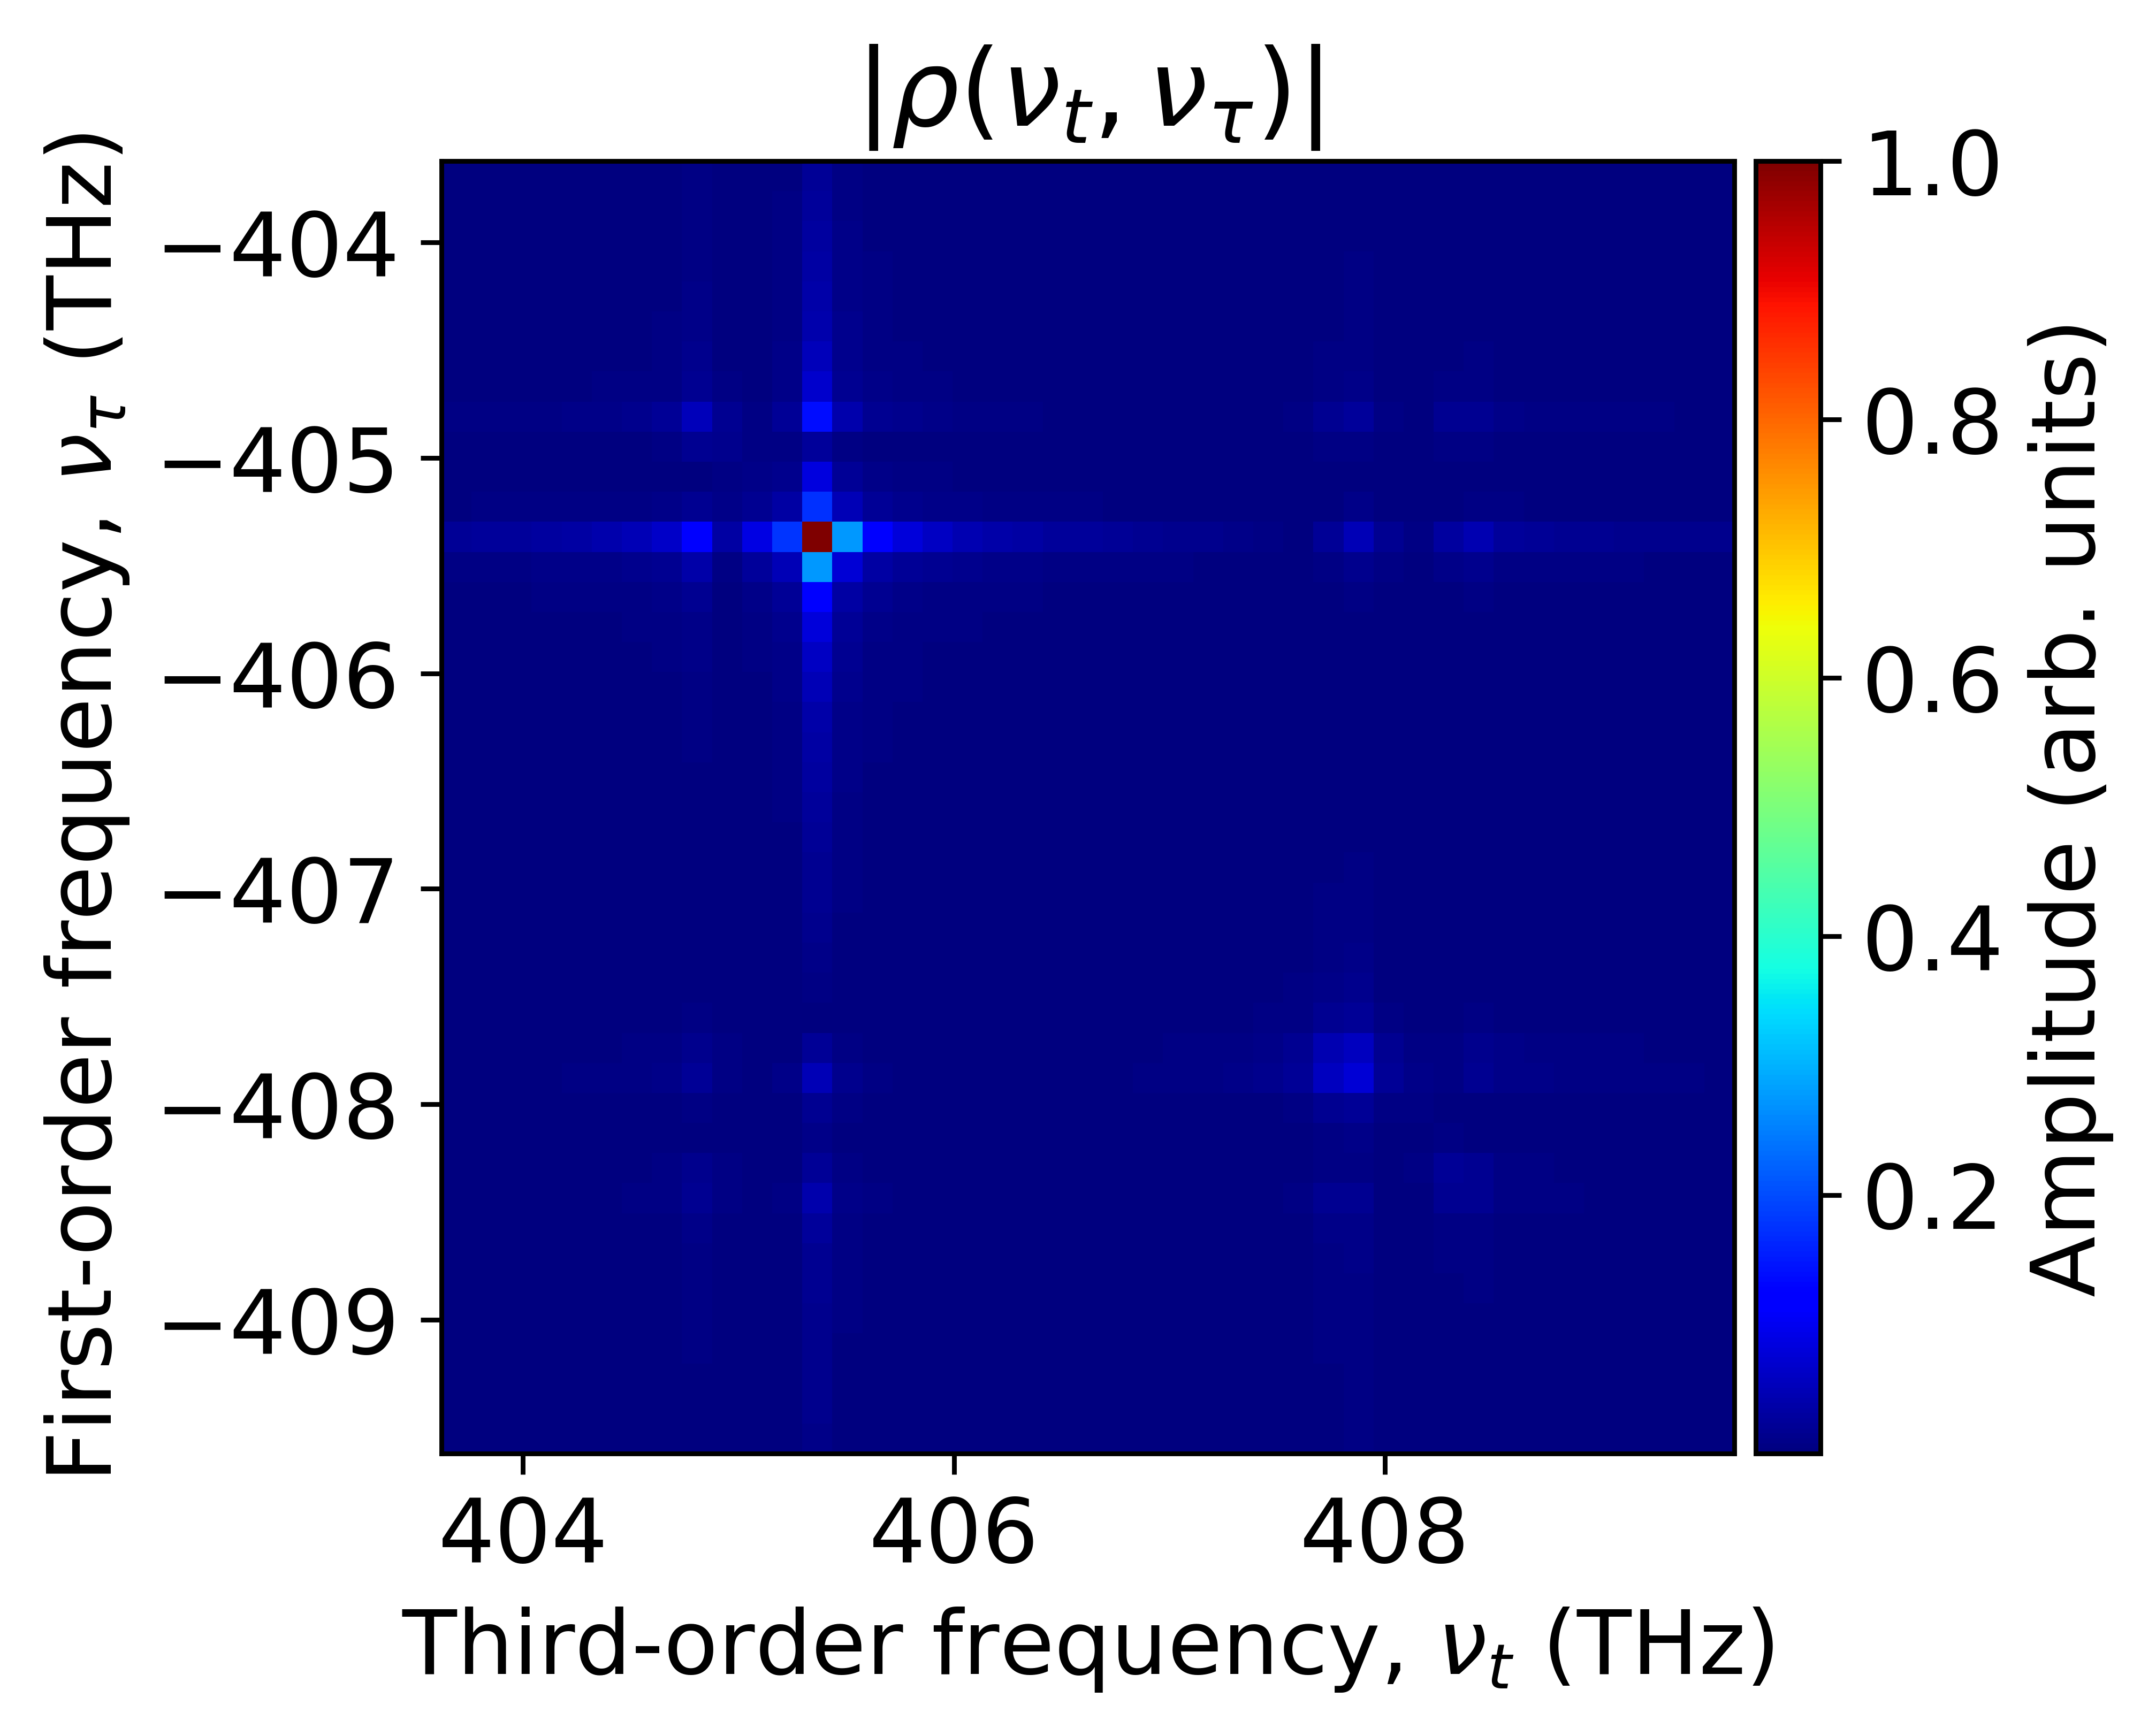

In [13]:
RHO = rho(nu_t_mesh, nu_tau_mesh)

minPlt = Delta_ZPL_0 - 0.25   # THz
maxPlt = Delta_ZPL_0 + 0.25  # THz

minInd_t = np.argmin(np.abs(nu_t-minPlt))
maxInd_t = np.argmin(np.abs(nu_t-maxPlt))

minInd_tau = np.argmin(np.abs(nu_tau+maxPlt))
maxInd_tau = np.argmin(np.abs(nu_tau+minPlt))

RHO = RHO[minInd_tau:maxInd_tau+1,minInd_t:maxInd_t+1]

EXTENT=(min(nu_t), max(nu_t), min(nu_tau), max(nu_tau))
# EXTENT=(Delta_ZPL_0 - 0.25, Delta_ZPL_0 + 0.25, -Delta_ZPL_0 - 0.25, -Delta_ZPL_0 + 0.25)
fig = plt.figure()
im = plt.imshow(np.sqrt(abs2(RHO)) / np.sqrt(abs2(np.max(RHO))), origin='lower', extent=EXTENT)
colorbar(im, 'Amplitude (arb. units)')
plt.ylabel(r'First-order frequency, $\nu_\tau$ (THz)')
plt.xlabel(r'Third-order frequency, $\nu_t$ (THz)')
plt.title(r'$\left |\rho (\nu_t, \nu_\tau) \right |$')
plt.show()

In [14]:
I_random6 = np.load(f"/Users/tommychin/Documents/research/Smallwood_research/paper/RightProj/I_random6.npy")

In [15]:
unstrained = np.load("/Users/tommychin/Documents/research/Smallwood_research/paper/SimpleProj/unstrained.npy")

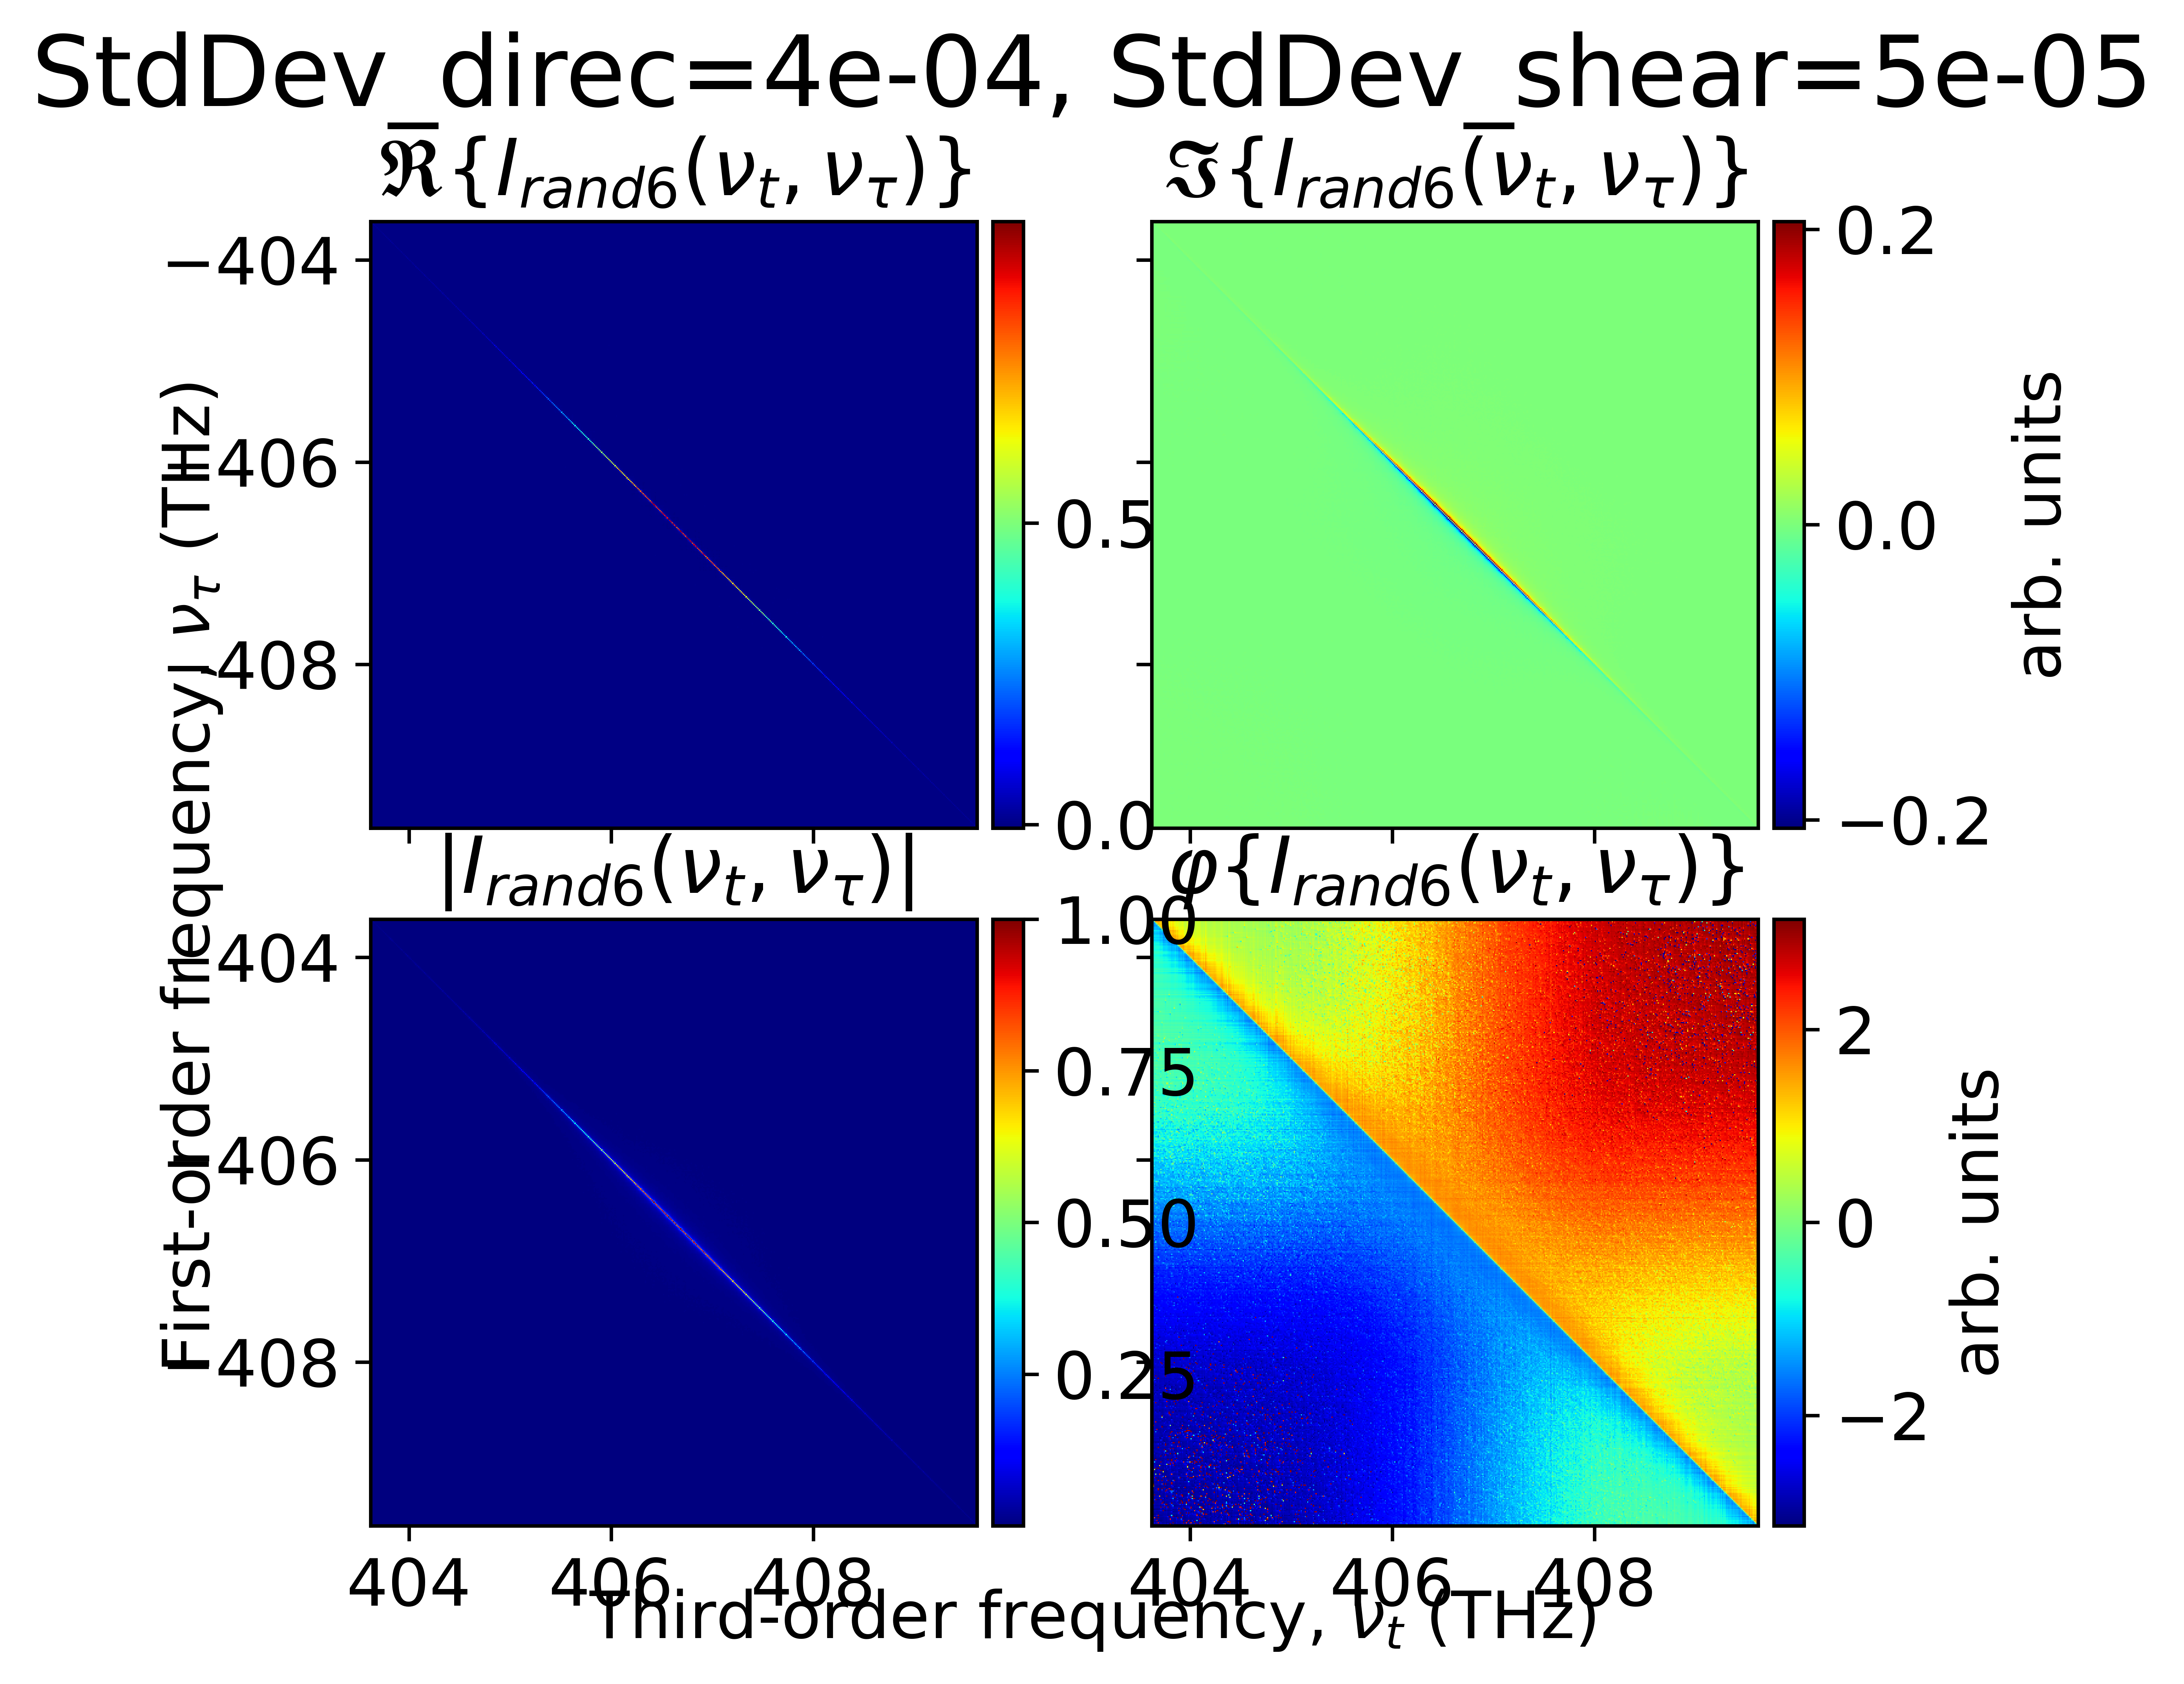

In [16]:
# minPlt = 405.5   # THz
# maxPlt = 408.75  # THz

minPlt = nu_t_min   # THz
maxPlt = nu_t_max  # THz

minInd_t = np.argmin(np.abs(nu_t-minPlt))
maxInd_t = np.argmin(np.abs(nu_t-maxPlt))

minInd_tau = np.argmin(np.abs(nu_tau+maxPlt))
maxInd_tau = np.argmin(np.abs(nu_tau+minPlt))

I_random6Plt = I_random6[minInd_tau:maxInd_tau+1,minInd_t:maxInd_t+1]

I_random6_ReImAmPh = np.array([I_random6Plt.real, 
                               I_random6Plt.imag, 
                               np.sqrt(abs2(I_random6Plt)), 
                               phase(I_random6Plt)])

fig_random6 = slices_plots(I_random6_ReImAmPh, 
                           shared_title='StdDev_direc=' 
                           f'{StdDev_direc:.0e}, ' 'StdDev_shear=' f'{StdDev_shear:.0e}',
                           shared_title_y_position=0.99,
                           figure_shape=[2,2], 
                           figure_size=[6,5.5],
                           titles=[r'$\mathfrak{R} \left\{I_{rand6} (\nu_t, \nu_\tau) \right\}$', 
                                   r'$\mathfrak{I} \left\{I_{rand6} (\nu_t, \nu_\tau) \right\}$',
                                   r'$             \left |I_{rand6} (\nu_t, \nu_\tau) \right |$',
                                   r'$     \varphi \left\{I_{rand6} (\nu_t, \nu_\tau) \right\}$'],
                           horizontal_gap=0.15,
                           shared_y_label_x_position=0.02, 
                           shared_x_label_y_position=0.06,
                           EXTENT=(nu_t[minInd_t], 
                                   nu_t[maxInd_t], 
                                   nu_tau[minInd_tau], 
                                   nu_tau[maxInd_tau])
                          )

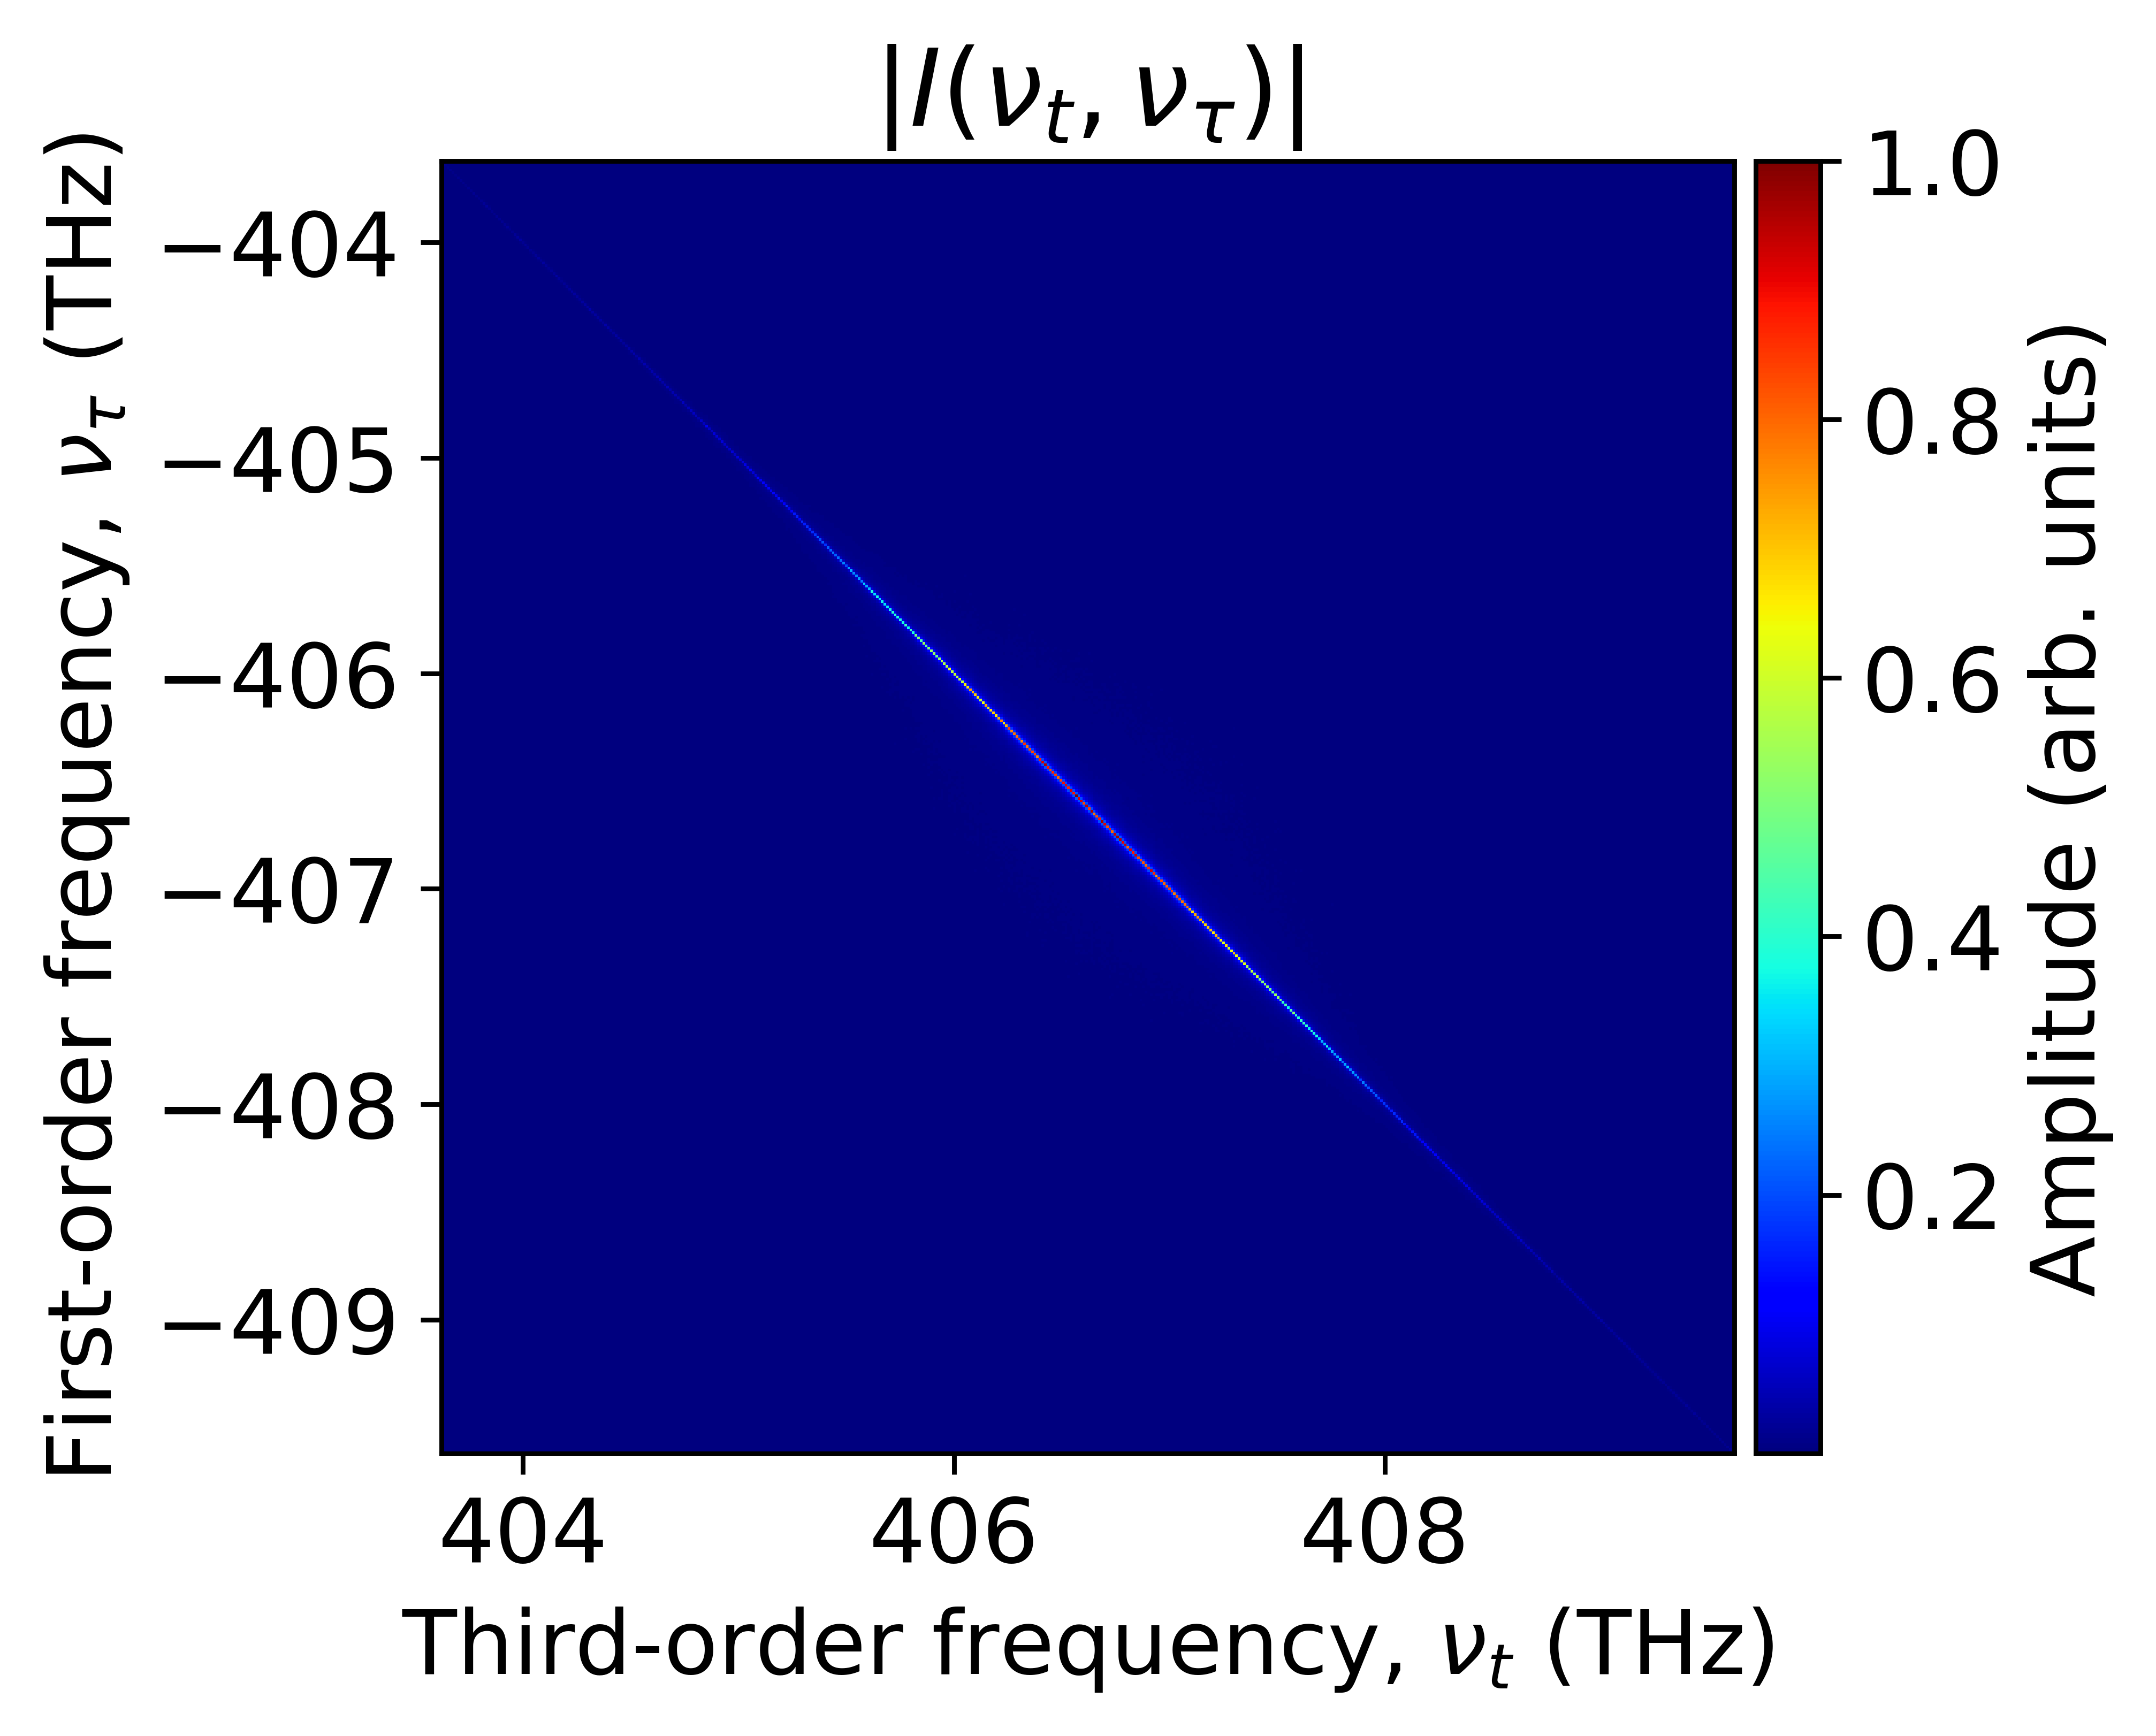

In [17]:
EXTENT=(min(nu_t), max(nu_t), min(nu_tau), max(nu_tau))
fig = plt.figure()

I_random6PltAmp = np.sqrt(abs2(I_random6Plt))
I_random6PltAmp /= np.max(I_random6PltAmp)

im = plt.imshow(I_random6PltAmp, origin='lower', extent=EXTENT)
colorbar(im, 'Amplitude (arb. units)')
plt.ylabel(r'First-order frequency, $\nu_\tau$ (THz)')
plt.xlabel(r'Third-order frequency, $\nu_t$ (THz)')
plt.title(r'$\left |I (\nu_t, \nu_\tau) \right |$')
plt.show()

fig.savefig("/Users/tommychin/Documents/research/Smallwood_research/paper/HeterodyneRand6.eps", 
                 format='eps', 
                 bbox_inches='tight')

# Noise filter https://stackoverflow.com/questions/37598986/reducing-noise-on-data

# signal shifting right problem https://dsp.stackexchange.com/questions/19084/applying-filter-in-scipy-signal-use-lfilter-or-filtfilt

In [18]:
def findMax(I_random6_proj, ax):
    n = 30  # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    a = 1.

    I_random6_proj_fill_amp = spsig.filtfilt(b, a, np.sqrt(abs2(I_random6_proj)))

    peaks, _ = spsig.find_peaks(I_random6_proj_fill_amp)
    results_half = spsig.peak_widths(I_random6_proj_fill_amp,
                                     peaks,
                                     rel_height=0.5)

    unstrained = np.sum(np.sqrt(abs2(rho(nu_t_mesh, nu_tau_mesh)
                                    )), axis=0)  # unstrained
    unstrained *= np.max(I_random6_proj_fill_amp) / np.max(unstrained)
    
    colors =  plt.cm.tab20( np.arange(4).astype(int) )

#     figproj = plt.figure(figsize=(8,3))
    ax.plot(nu_t, unstrained, label='unstrained', c='C0')
    ax.plot(nu_t, I_random6_proj, c=colors[3])
    ax.plot(nu_t, I_random6_proj_fill_amp, c='C1',
             label='strained')  # smooth by filter

    for i in range(len(peaks)):

        if i == np.argmax(results_half[0]):
            color='C3'
            Alpha=1
        else:
            color='C4'
            Alpha=0.5

        ax.plot(nu_t[peaks[i]],
                 I_random6_proj_fill_amp[peaks[i]],
                 "x",
                 c='C2',
                 alpha=Alpha)
        ax.hlines(results_half[1][i],
                   results_half[2][i] / res * (nu_t_max - nu_t_min) + nu_t_min,
                   results_half[3][i] / res * (nu_t_max - nu_t_min) + nu_t_min,
                   color="C2",
                   alpha=Alpha)
        ax.text(nu_t[peaks[i]],
                 results_half[1][i],
                 f'FWHM={results_half[0][i]/res*(nu_t_max-nu_t_min) :.2f}',
                 c=color,
                 alpha=Alpha,
                 ha='center',
                 va='top')
    ax.legend(labelcolor='k', loc='best', fancybox=True, framealpha=0)
    return

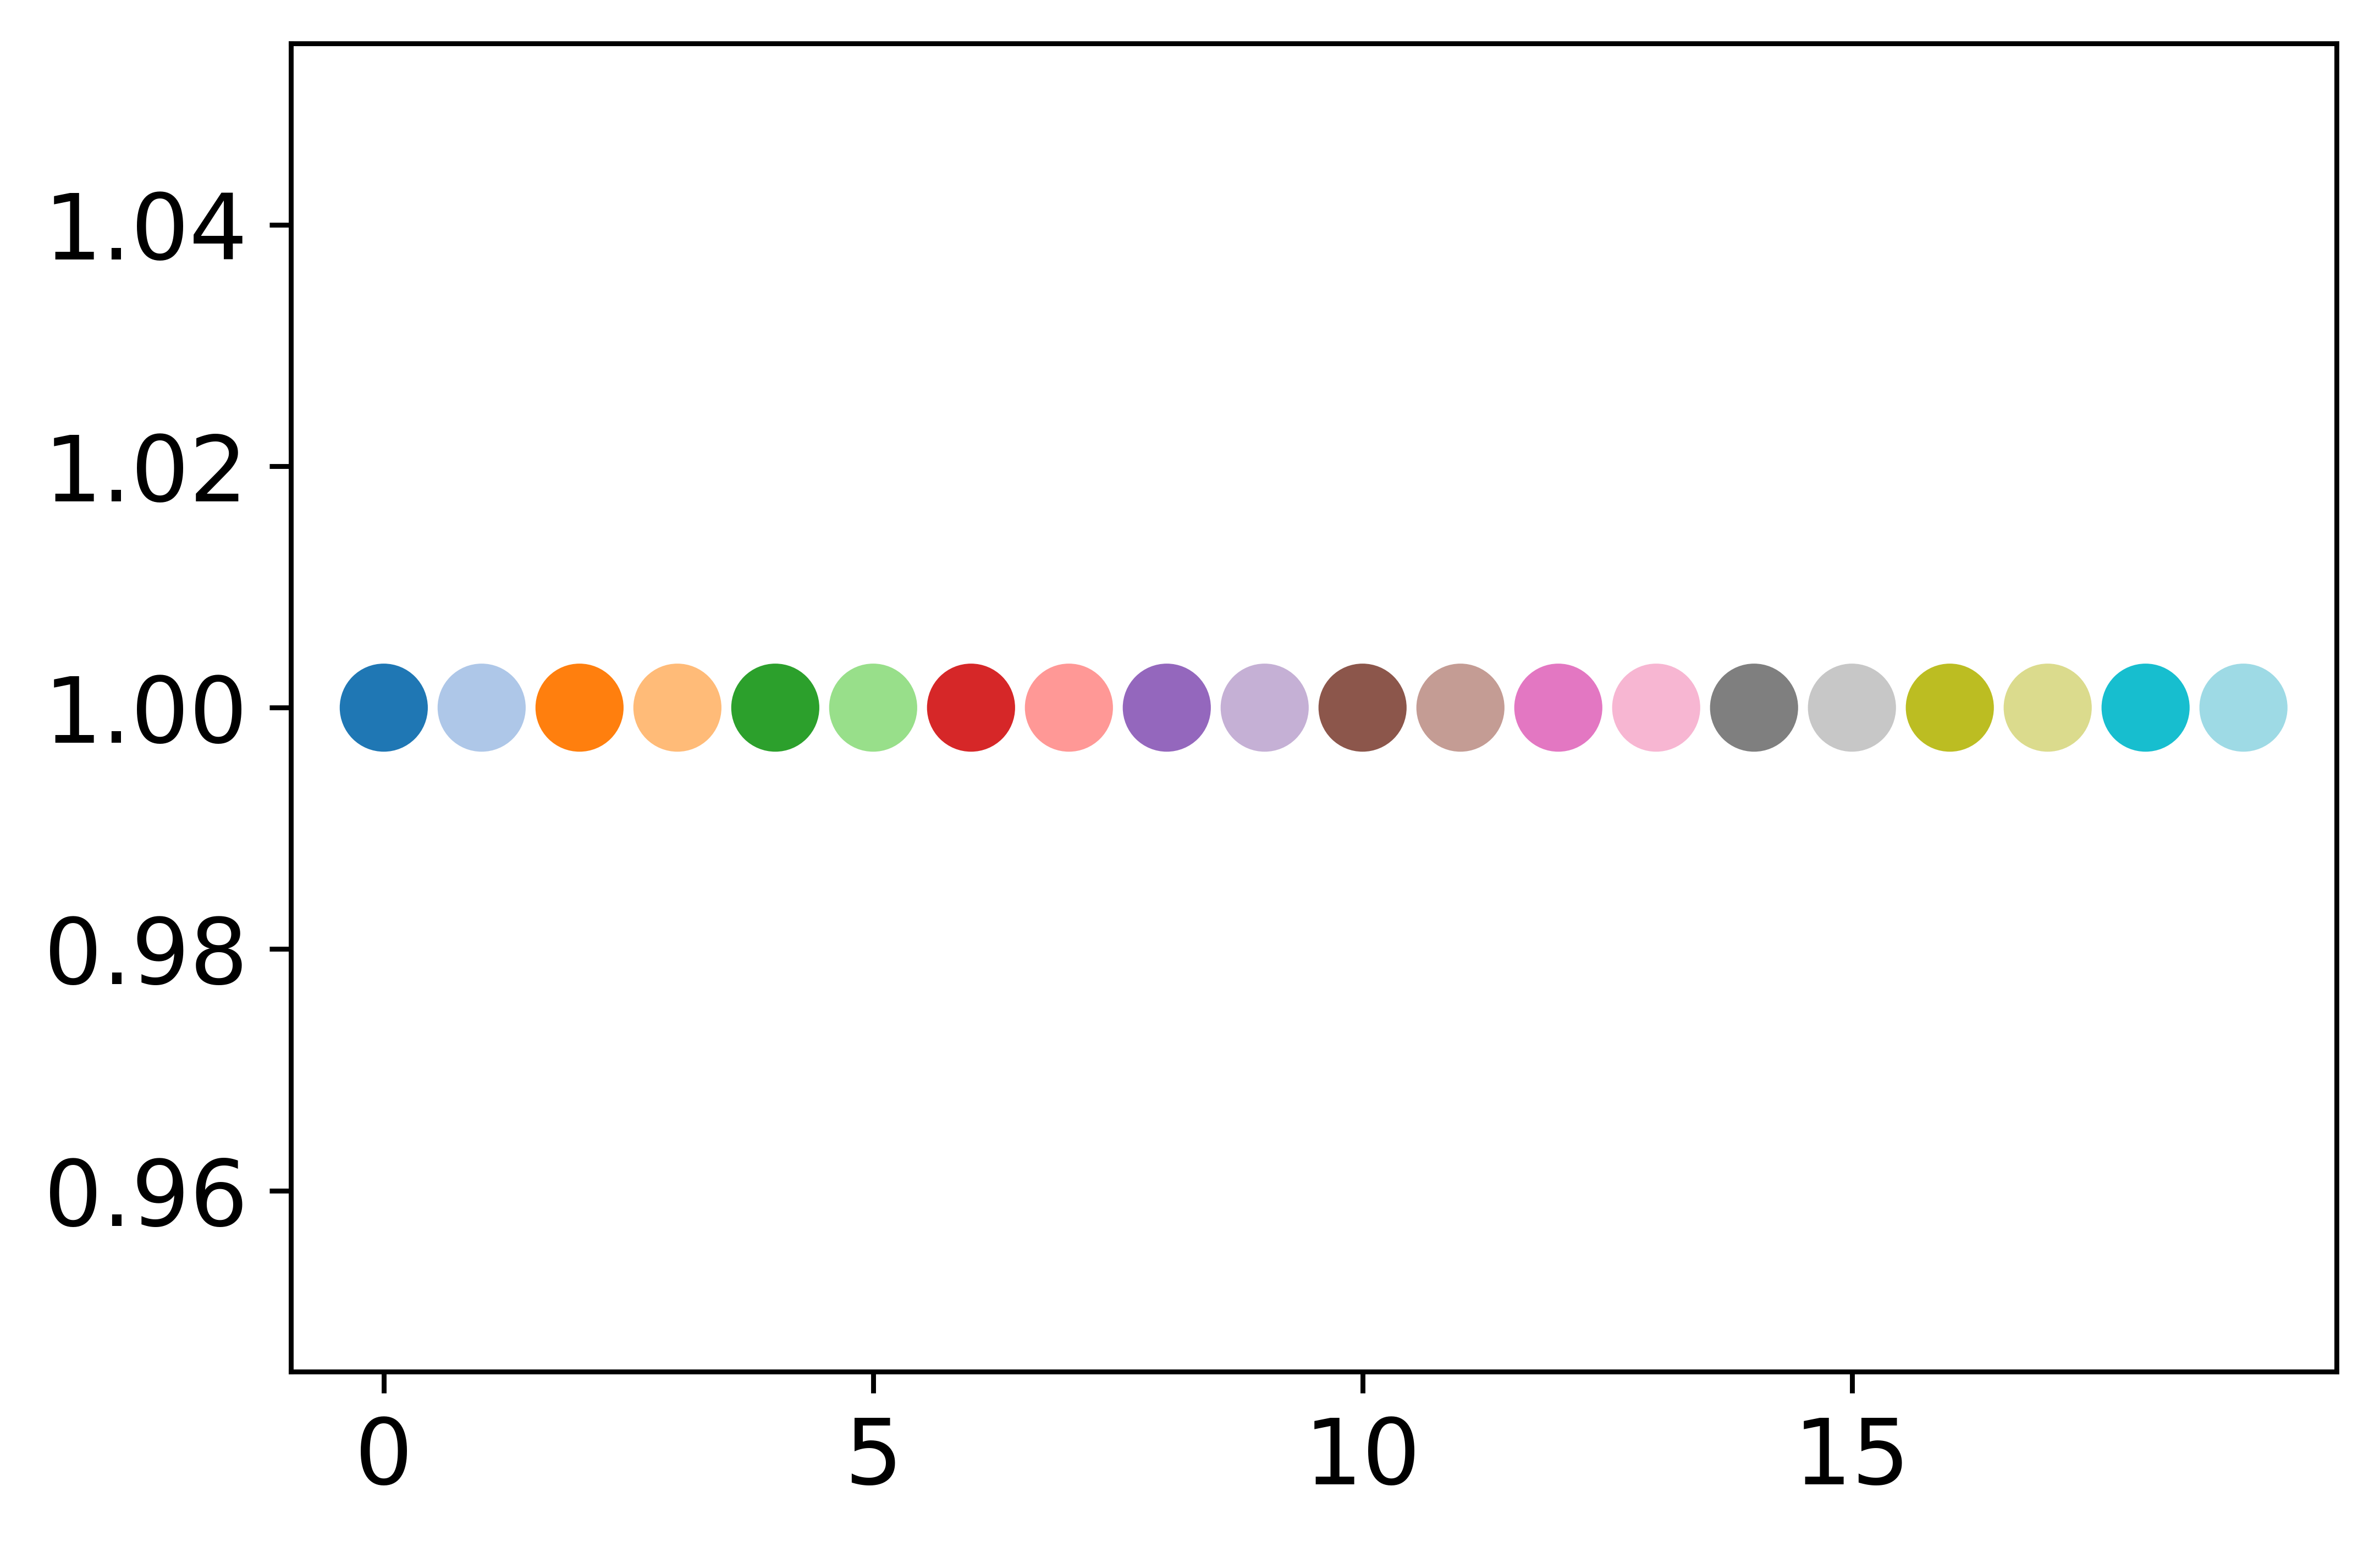

In [19]:
colors =  plt.cm.tab20( np.arange(20).astype(int) )
plt.scatter(np.arange(20),np.ones(20), c=colors, s=180)

plt.show()

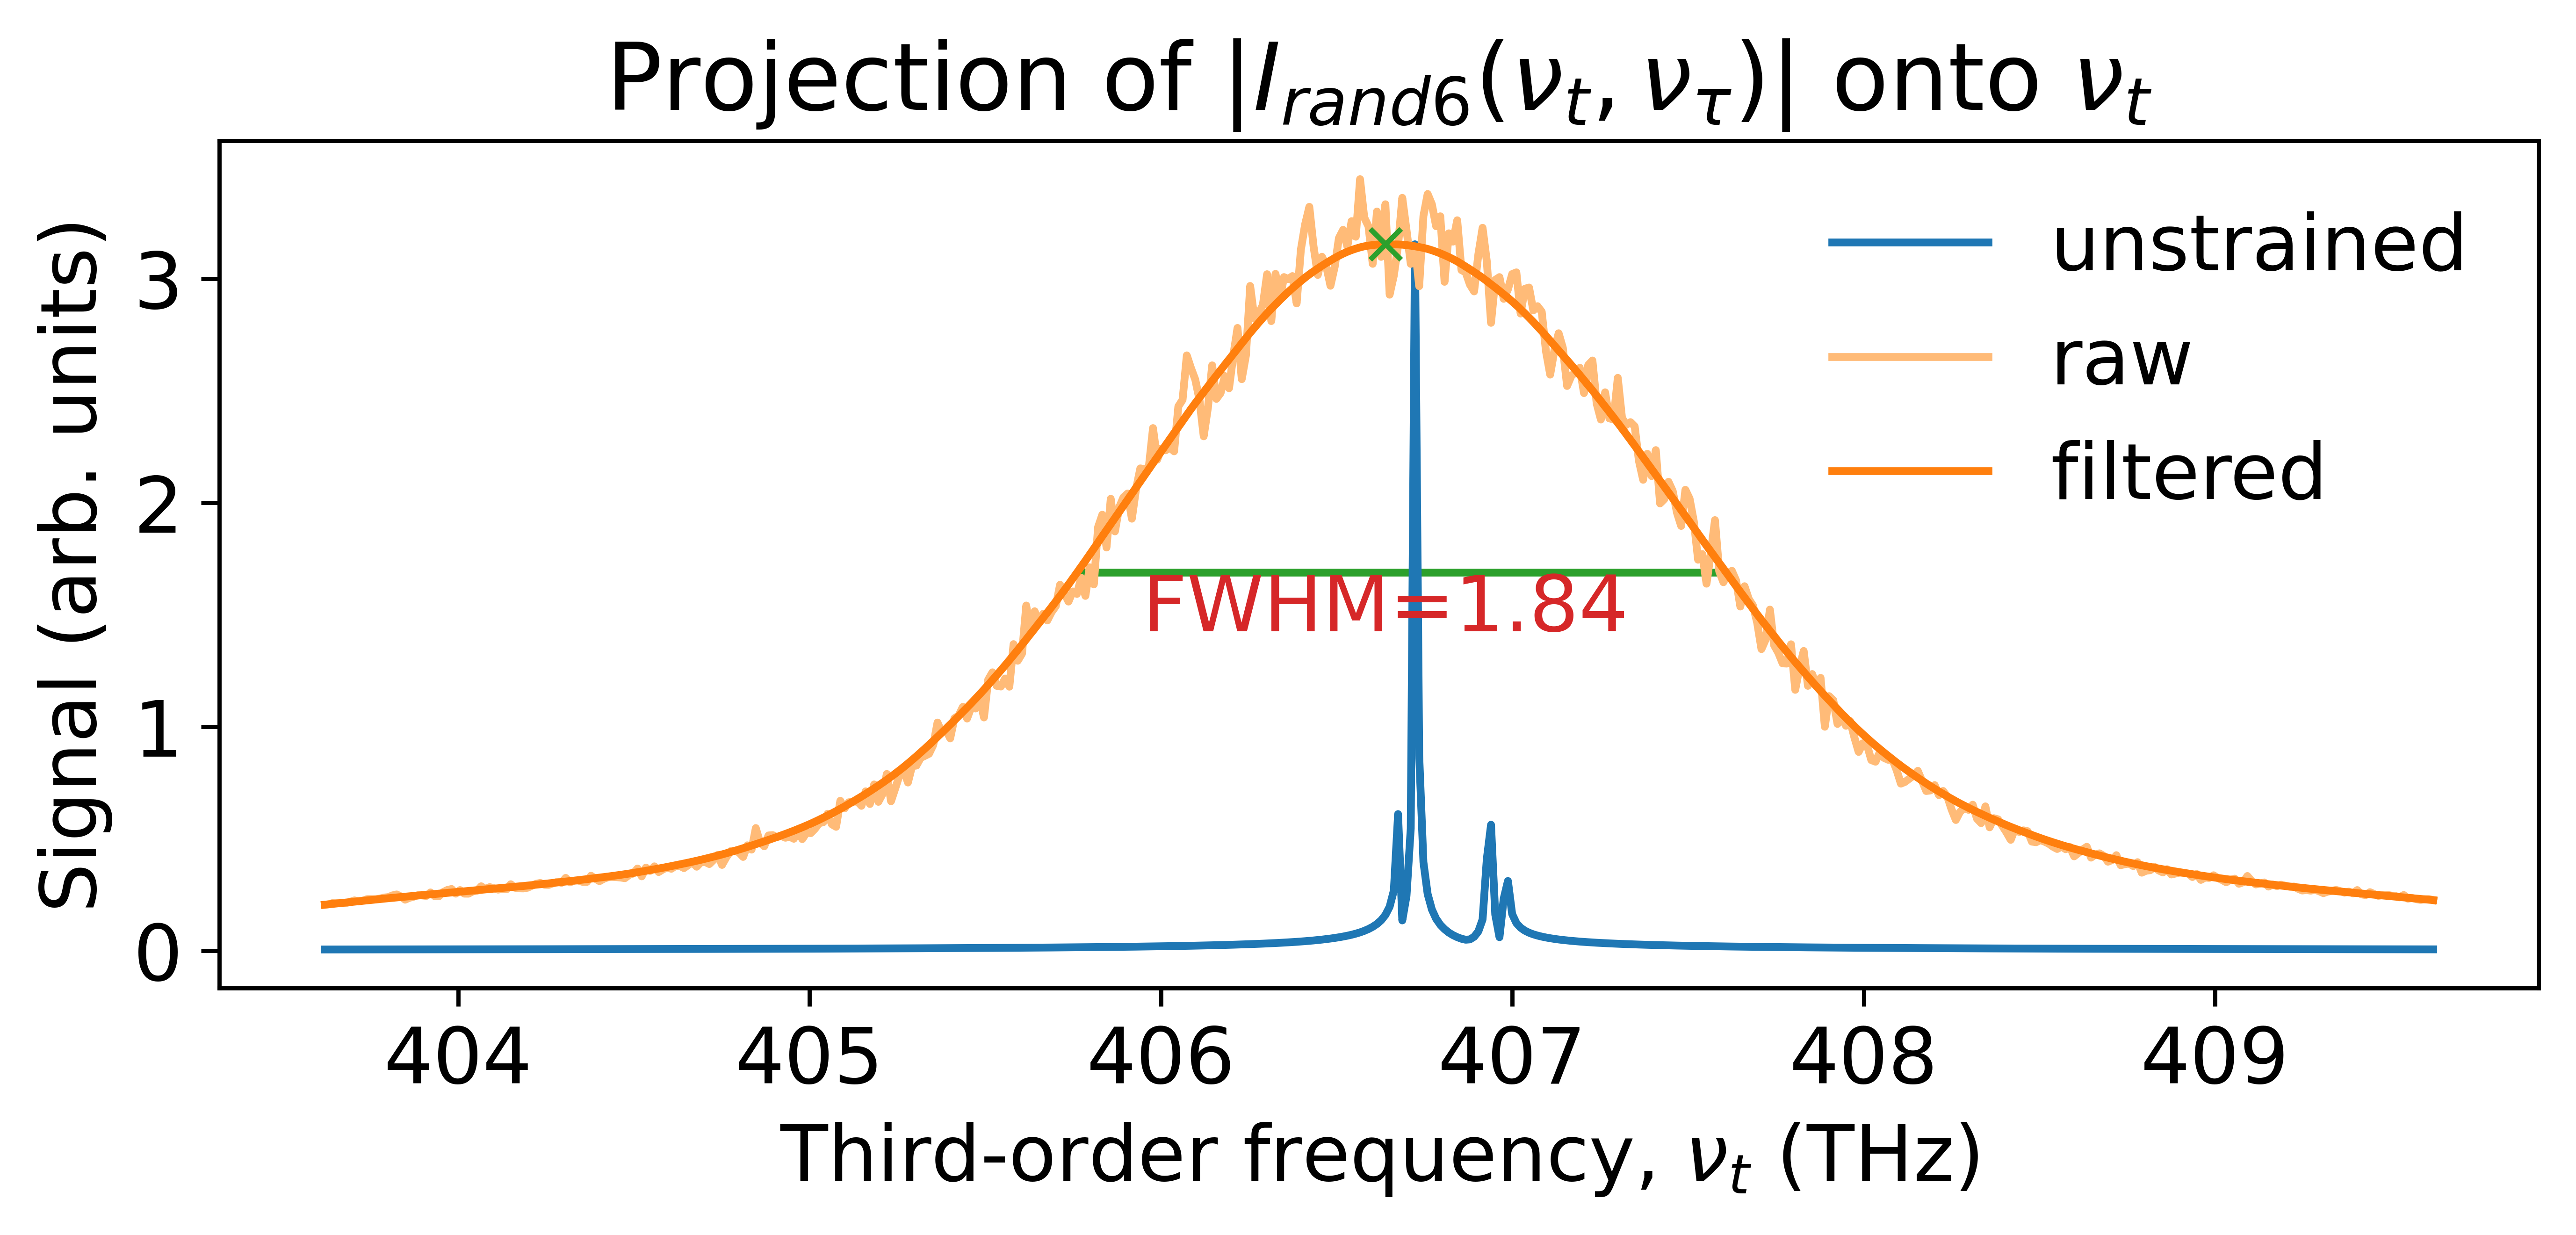

In [20]:
I_random6_proj = np.sum(I_random6PltAmp, axis=0)  # Projecting onto nu_t axis

n = 30  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1.

I_random6_proj_fill_amp = spsig.filtfilt(b, a, np.sqrt(abs2(I_random6_proj)))

peaks, _ = spsig.find_peaks(I_random6_proj_fill_amp)
results_half = spsig.peak_widths(I_random6_proj_fill_amp,
                                 peaks,
                                 rel_height=0.5)

unstrained = np.sum(np.sqrt(abs2(rho(nu_t_mesh, nu_tau_mesh)
                                )), axis=0)  # unstrained
unstrained *= np.max(I_random6_proj_fill_amp) / np.max(unstrained)

figproj = plt.figure(figsize=(8,3))
plt.plot(nu_t, unstrained, label='unstrained')

plt.plot(nu_t, I_random6_proj, label='raw', c=colors[3])
plt.plot(nu_t, I_random6_proj_fill_amp, c='C1',
         label='filtered')  # smooth by filter

for i in range(len(peaks)):

    if i == np.argmax(results_half[0]):
        color='C3'
        Alpha=1
    else:
        color='C4'
        Alpha=0.5

    plt.plot(nu_t[peaks[i]],
             I_random6_proj_fill_amp[peaks[i]],
             "x",
             c='C2',
             alpha=Alpha)
    plt.hlines(results_half[1][i],
               results_half[2][i] / res * (nu_t_max - nu_t_min) + nu_t_min,
               results_half[3][i] / res * (nu_t_max - nu_t_min) + nu_t_min,
               color="C2",
               alpha=Alpha)
    plt.text(nu_t[peaks[i]],
             results_half[1][i],
             f'FWHM={results_half[0][i]/res*(nu_t_max-nu_t_min) :.2f}',
             c=color,
             alpha=Alpha,
             ha='center',
             va='top')
plt.legend(labelcolor='k', loc='best', fancybox=True, framealpha=0)
plt.title(
    r'Projection of $\left |I_{rand6} (\nu_t, \nu_\tau) \right |$ onto $\nu_t$')
# plt.title(
#     r'StdDev_direc=' 
#     f'{StdDev_direc:.0e}, ' 'StdDev_shear=' f'{StdDev_shear:.0e}')
plt.xlabel(r'Third-order frequency, $\nu_t$ (THz)')
plt.ylabel(r'Signal (arb. units)')
plt.show()

figproj.savefig("/Users/tommychin/Documents/research/Smallwood_research/paper/HeterodyneRand6Proj.pdf", 
                 format='pdf', 
                 bbox_inches='tight')

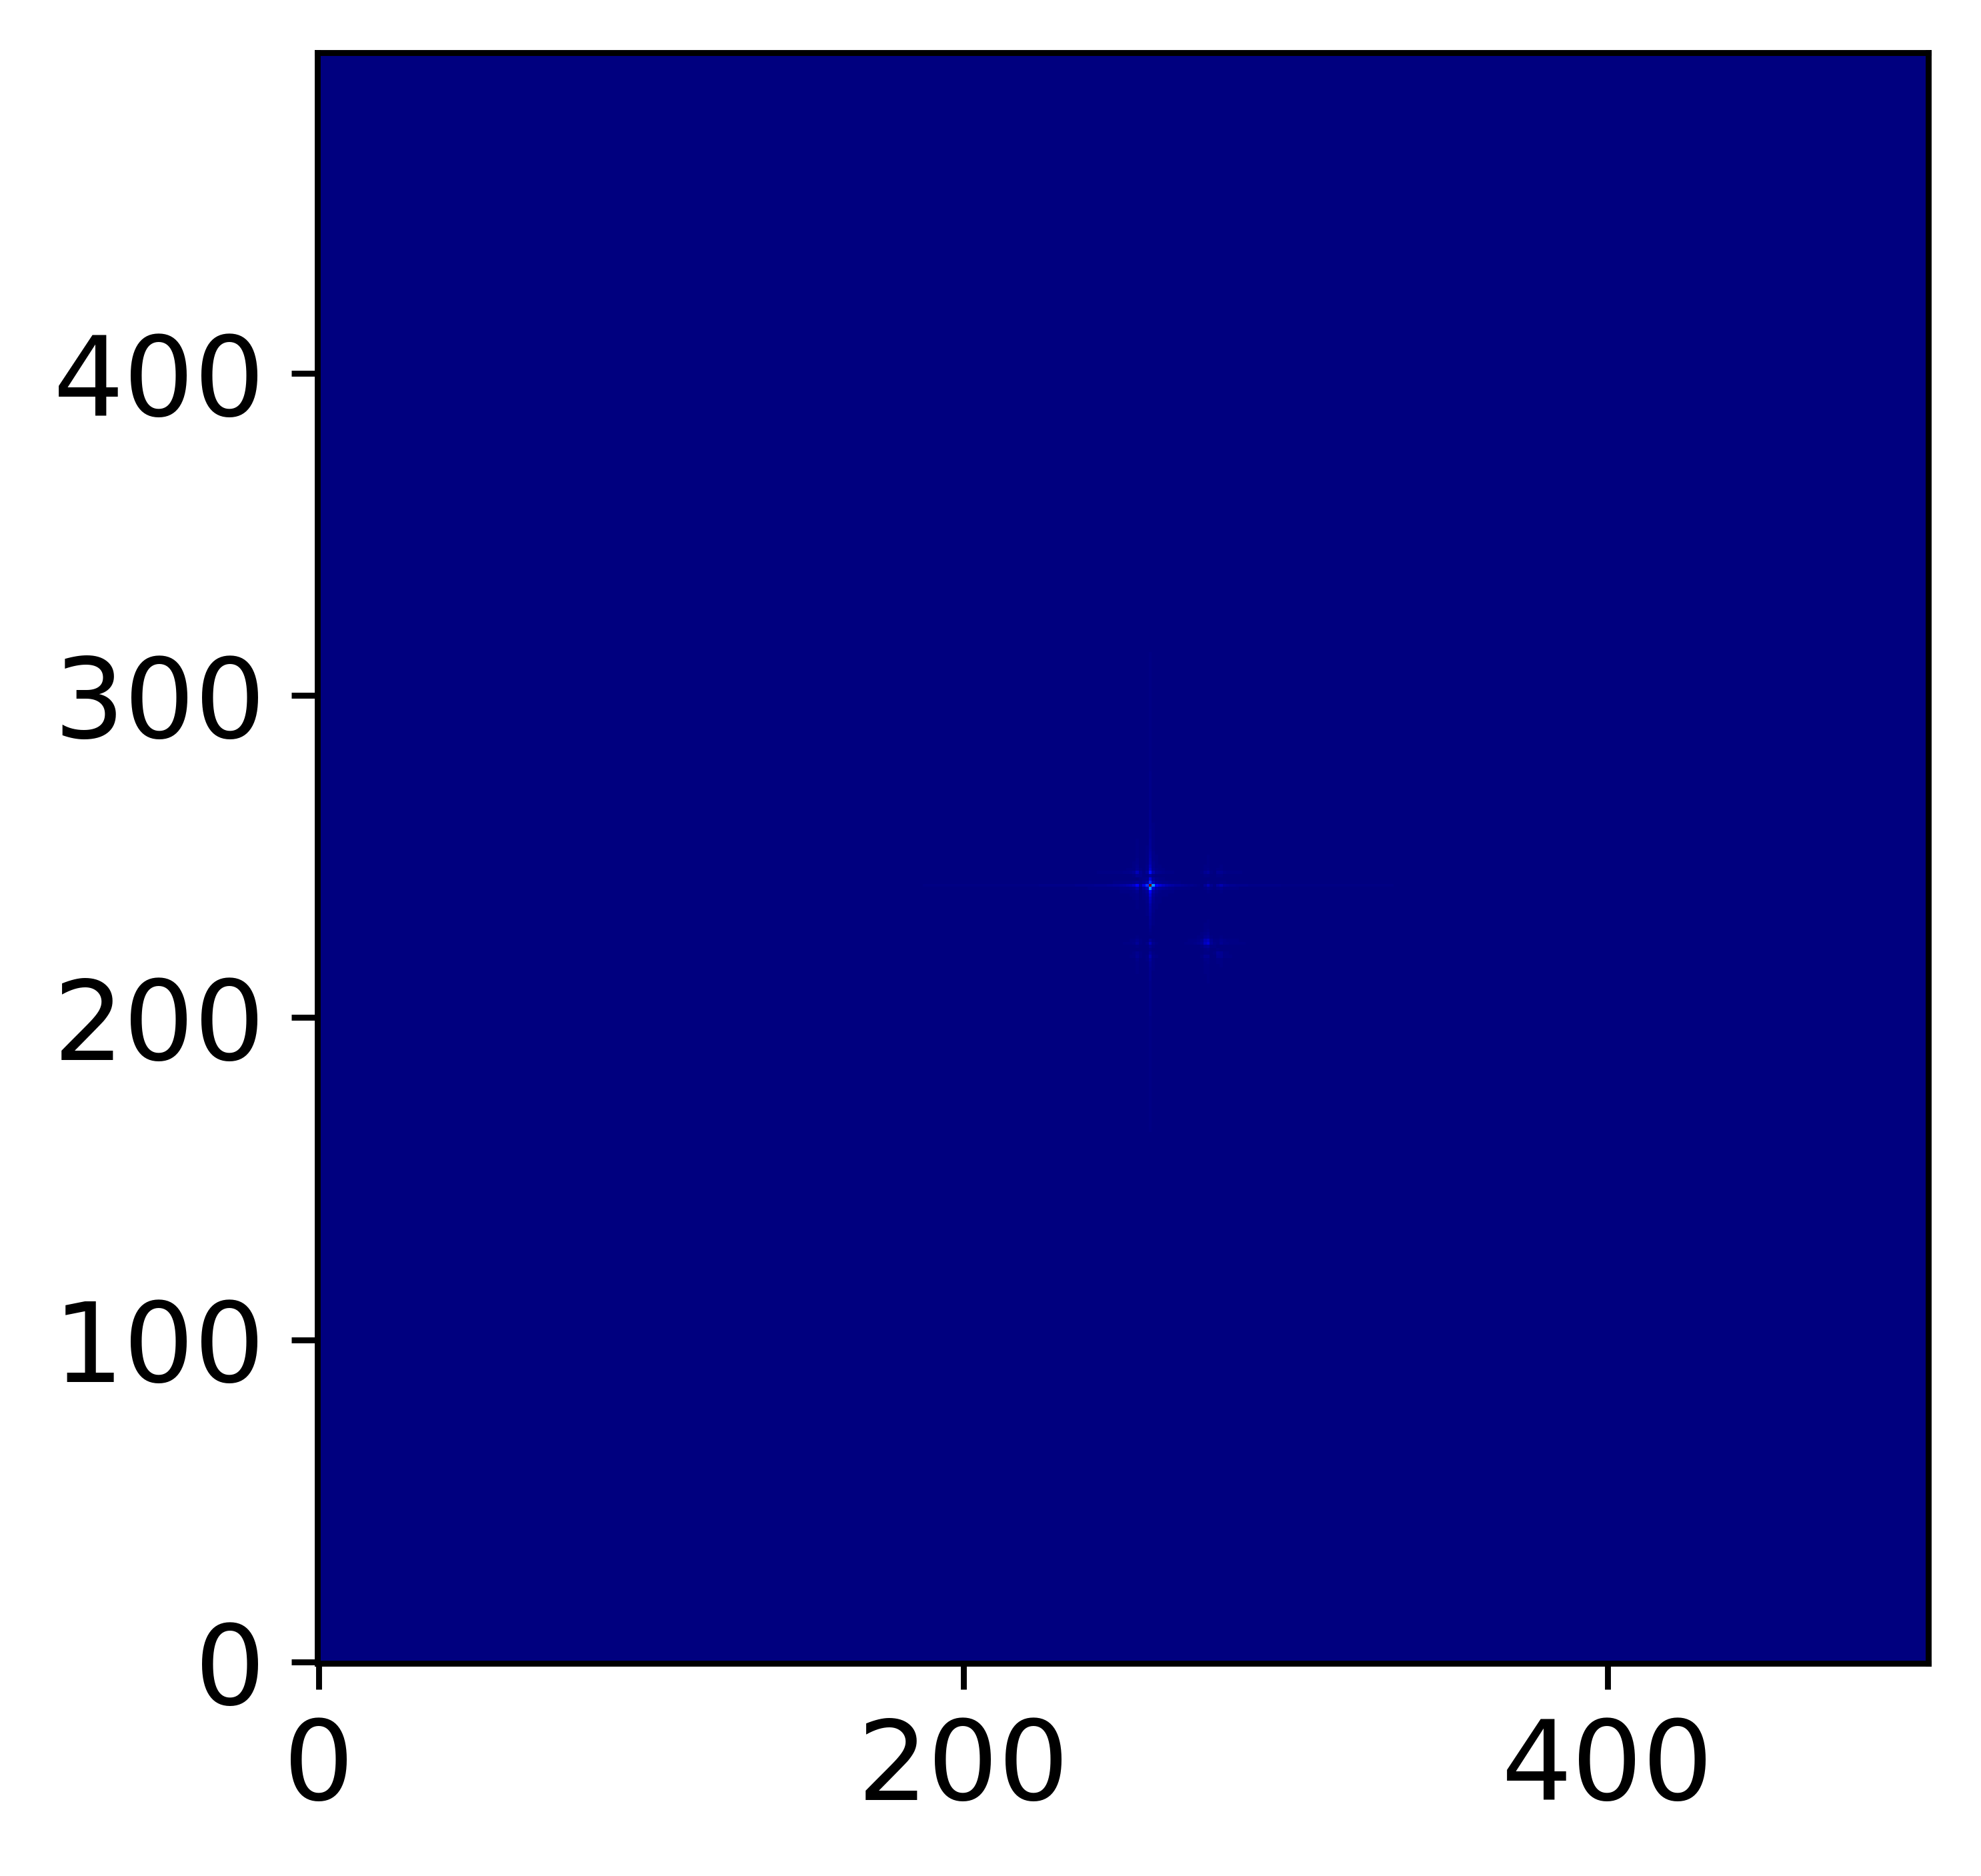

In [21]:
plt.figure()
plt.imshow(np.sqrt(abs2(rho(nu_t_mesh, nu_tau_mesh))), origin='lower')
plt.show()

In [38]:
def projPlot(Z):

    from mpl_toolkits.axes_grid1 import make_axes_locatable

    x = np.sum(Z, axis=0)
#     y = np.sum(Z, axis=1)

    x /= max(x)
#     y /= max(y)

    fig, ax = plt.subplots(figsize=(7, 8))
    EXTENT=(minPlt, maxPlt, -maxPlt, -minPlt)
    im = ax.imshow(Z, origin='lower', extent=EXTENT)
    
#     unstrained_x = np.sum(unstrained, axis=0)
#     unstrained_x /= max(unstrained_x)

    # create new axes on the right and on the top of the current axes.
    divider = make_axes_locatable(ax)
    axtop = divider.append_axes("top", size="25%", pad=0.05, sharex=ax)
#     axright = divider.append_axes("right", size="25%", pad=0.05, sharey=ax)

    label='arb. units'
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    if label is not None:
        plt.ylabel(label)

    #plot to the new axes
#     axtop.plot(nu_t[minInd_t: maxInd_t+1], unstrained_x, label='unstrained')
#     axtop.plot(nu_t[minInd_t: maxInd_t+1], x, label='strained')

    findMax(x, axtop)
    
#     axright.plot(y, nu_tau[minInd_tau: maxInd_tau+1])
    axtop.get_xaxis().set_visible(False)
#     axright.get_yaxis().set_visible(False)

    axtop.spines['top'].set_visible(False)
    axtop.spines['right'].set_visible(False)

    ax.set_ylabel(r'First-order frequency, $\nu_\tau$ (THz)')
    ax.set_xlabel(r'Third-order frequency, $\nu_t$ (THz)')
    axtop.set_title(r'$\left |S_{rand6} (\nu_t, \nu_\tau) \right |$')

    #adjust margins
#     axright.margins(y=0)
    axtop.margins(x=0)
    plt.tight_layout()
    plt.show()
    return fig

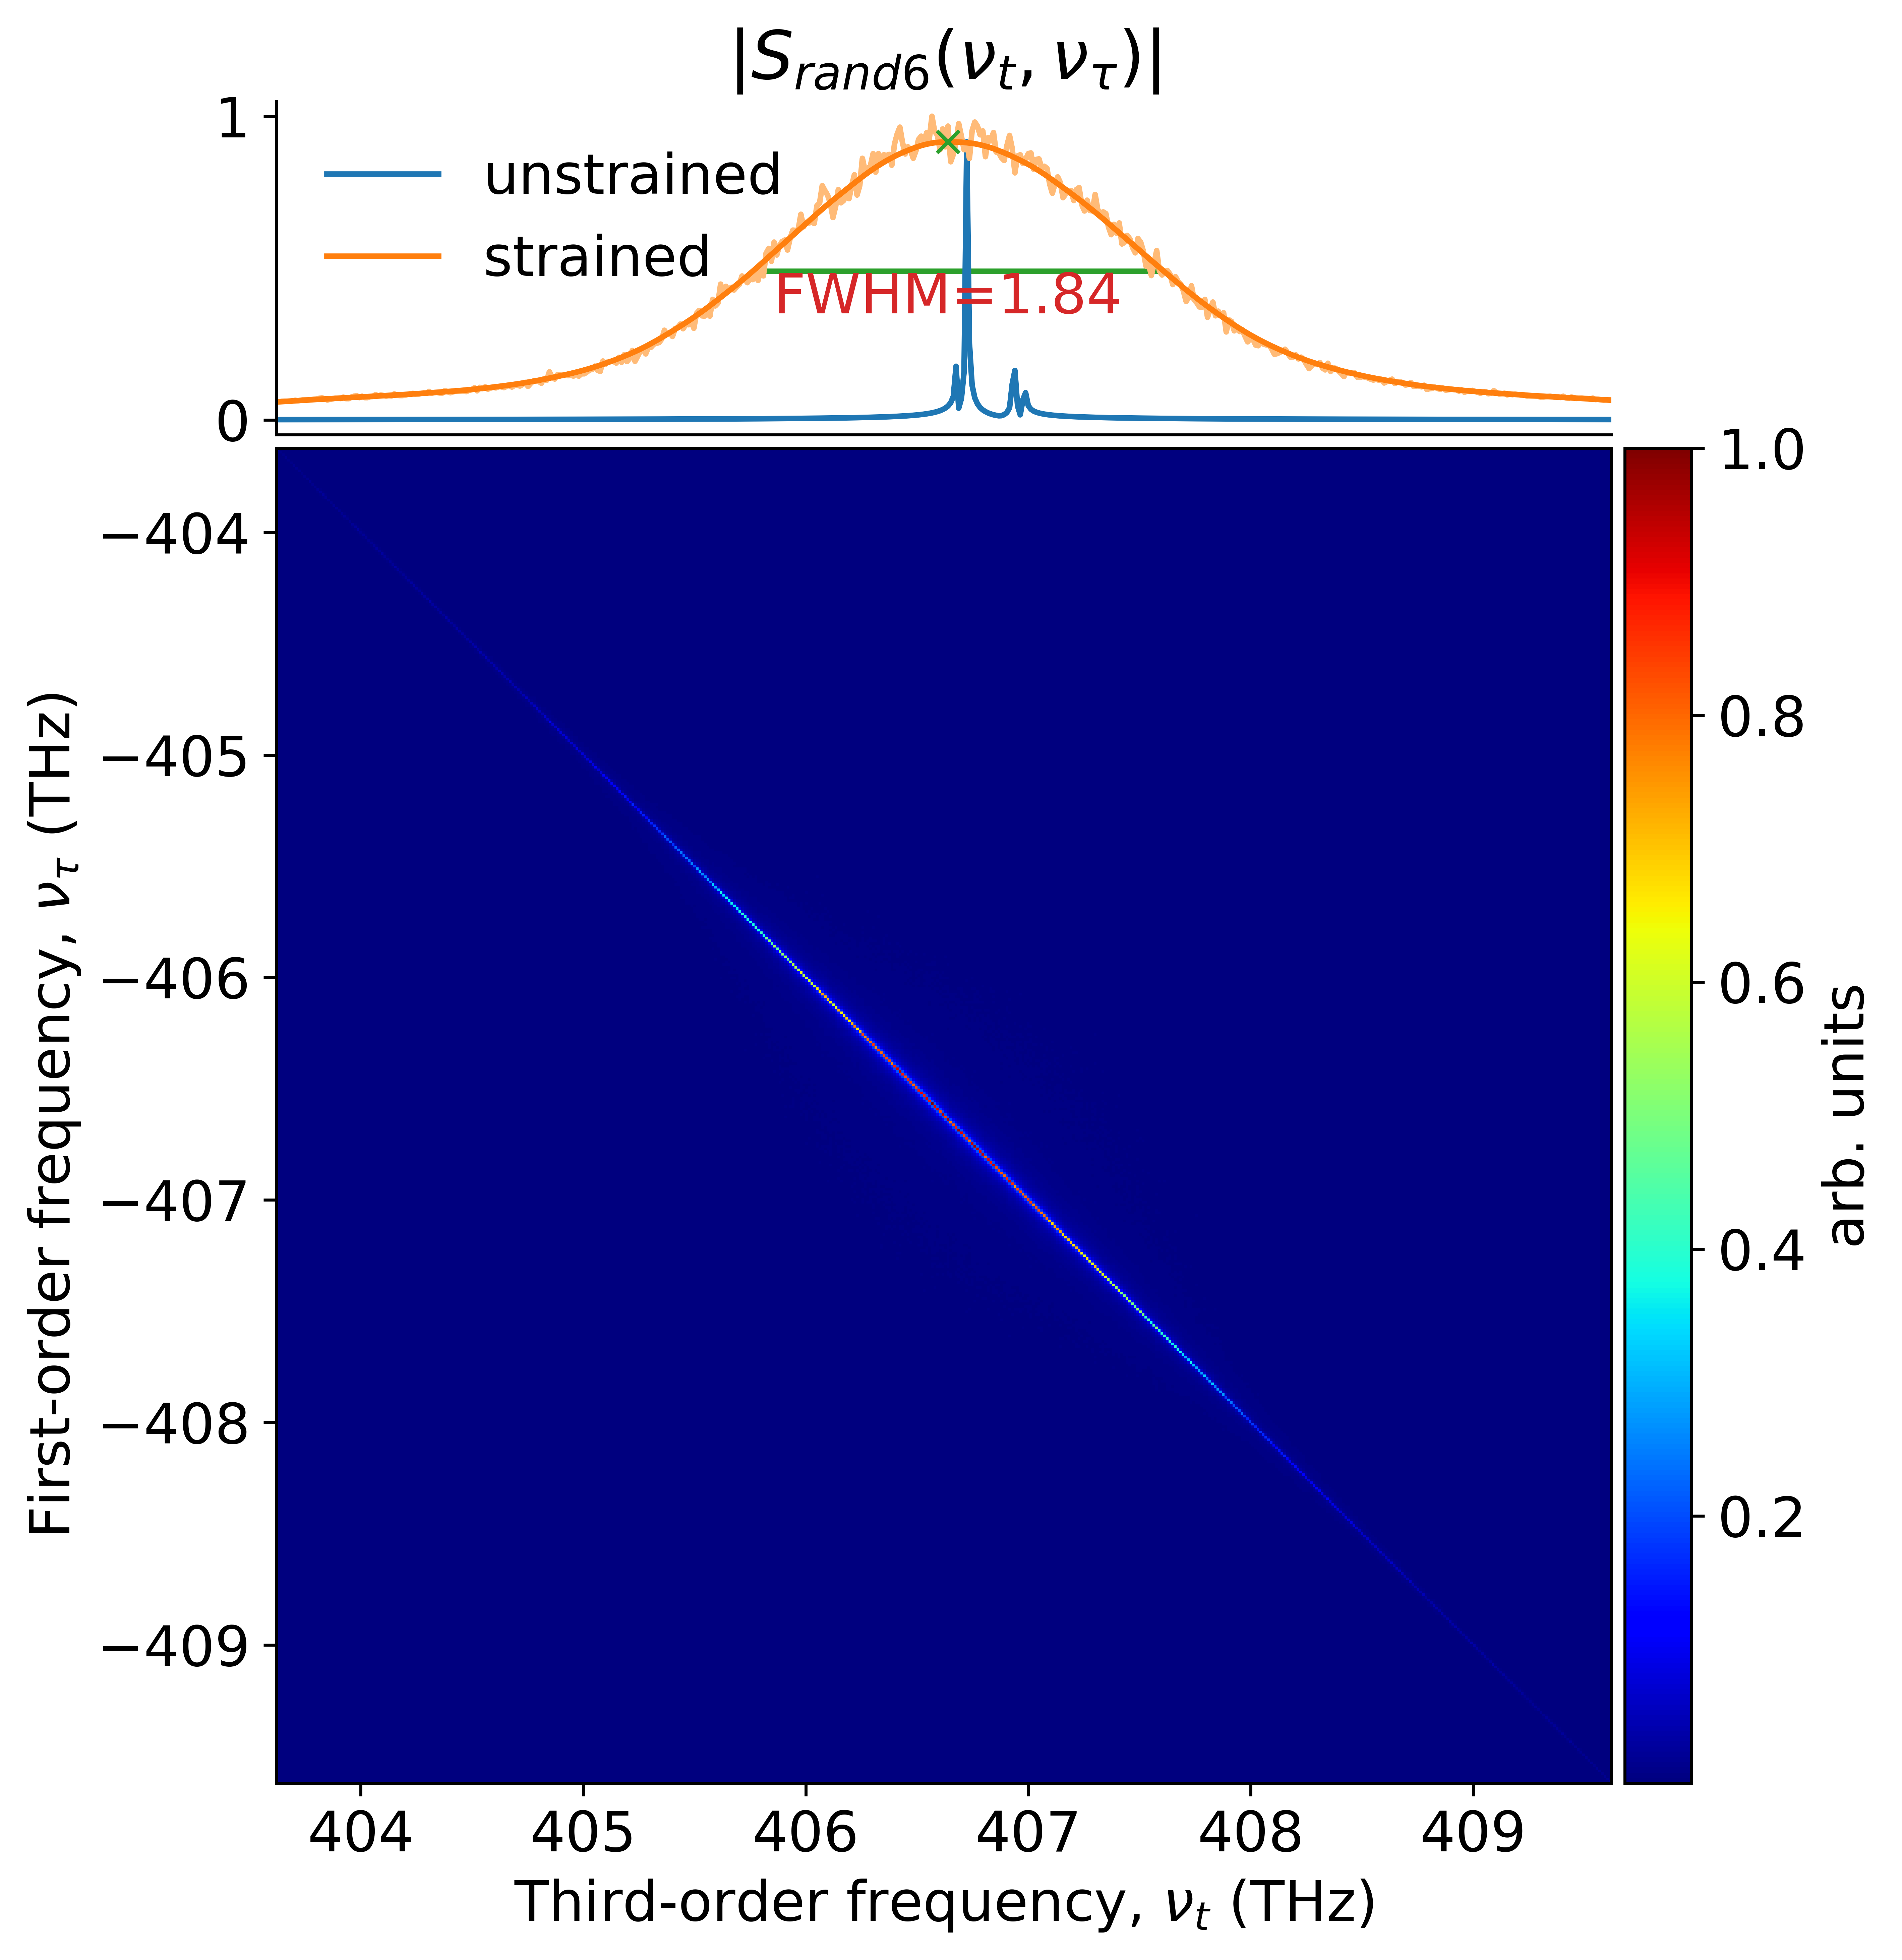

In [39]:
I_random6ProjPlot = np.sqrt(abs2(I_random6))
I_random6ProjPlot /= np.max(I_random6ProjPlot)

Rand6 = projPlot(I_random6ProjPlot)

Rand6.savefig("/Users/tommychin/Documents/research/Smallwood_research/paper/Rand6.eps", 
                 format='eps', 
                 bbox_inches='tight')

Lorentz.savefig("/Users/tommychin/Documents/research/Smallwood_research/paper/rand6.eps", 
                 format='eps', 
                 bbox_inches='tight')

FWHMdata_MC1e4_strn2p425en4 = np.array([1.82, 1.71])

FWHMdata_MC1e4_strn2p45en4 = np.array([1.86, 1.86])

FWHMdata_MC1e4_strn2p4en4 = np.array([1.72])

FWHMdata_MC1e4_strn2p35en4 = np.array([1.76])

FWHMdata_MC1e4_strn2p25en4 = np.array([1.76])

FWHMdata_MC1e4_strn2p5en4 = np.array([1.82, 1.83, 1.79, 1.88, 1.90, 1.77, 1.81])

FWHMdata_MC5e3_strn2p5en4 = np.array([1.67, 1.79, 1.83, 1.69, 2.1, 1.88, 1.92, 2.02, 1.78, 1.89, 2.04])
plt.hist(FWHMdata_MC1e4_strn2p5en4, bins=len(FWHMdata_MC1e4_strn2p5en4))
plt.show()

np.mean(FWHMdata_MC1e4_strn2p5en4)

np.mean(FWHMdata_MC5e3_strn2p5en4)